In [89]:
import sys
import os
import pathlib
import json
import pyvista as pv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


working_dir = pathlib.Path(os.path.abspath(""))
sys.path.append(str(working_dir.parent))
from runs import find_runs  # noqa: E402

### Load data and calculate error

In [90]:
def load_data(runs_dir: pathlib.Path) -> pd.DataFrame:
    """Load the data from the runs in the given directory.
    Calculate the position error between timestep 0 and 2000

    Args:
        runs_dir: The directory containing the runs.
        timestep: The timestep to load.

    Return:
        A pandas DataFrame containing the data. The index is the grid spacing and
        the columns are the different mappings.
    """

    # Find the runs, we are interested in
    runs = find_runs(runs_dir)

    # Load the data
    data = {}  # Raw data: {grid_spacing: {timestep: error_value}}

    for run_path in runs:
        # Read parameters of the run
        with open(run_path / "parameters.json") as file:
            parameters = json.load(file)

        # Generate descriptive column name
        column_name = {
            "nearest-neighbor": "NN",
            "rbf-pum-direct": "RBF",
        }[parameters["mapping"]]

        if parameters["mapping"] == "rbf-pum-direct":
            column_name += (
                " "
                + {
                    "compact-polynomial-c0": "CP0",
                    "compact-polynomial-c2": "CP2",
                    "compact-polynomial-c4": "CP4",
                    "compact-polynomial-c6": "CP6",
                    "compact-polynomial-c8": "CP8",
                }[parameters["basis_function"]]
            )
            # column_name += f"_{parameters['support_radius']}"

        # Calculate grid spacing from refinement level
        grid_spacing = 1 / 2 ** parameters["refinement"]

        # Calculate position error
        try:
            file_name_begin = f"refinement-{parameters['refinement']}_particles_000000.pvtu"
            file_name_end = f"refinement-{parameters['refinement']}_particles_999999.pvtu"

            mesh_begin = pv.read(run_path / "solution" / file_name_begin)
            mesh_end = pv.read(run_path / "solution" / file_name_end)

            mesh_end["error"] = np.linalg.norm(mesh_begin.points - mesh_end.points, axis=1)

            mean_error = mesh_end["error"].mean()

        except Exception:
            mean_error = np.nan

        # Insert error into data dict
        if column_name not in data:
            data[column_name] = {}
        data[column_name][grid_spacing] = mean_error

    # Convert data dict to pandas DataFrame
    return (
        pd.DataFrame(data)
        .sort_index(axis=0, ascending=False)
        .sort_index(axis=1, ascending=False)
    )


df = load_data(working_dir.parent / "runs" / "convergence_over_grid_spacing")
df

,RBF CP4,RBF CP0,NN
0.250000,0.061817,0.062855,0.062320
0.125000,0.055358,0.056387,0.055563
0.062500,0.028552,0.028531,0.027840
0.031250,0.013552,0.013517,0.013288
0.015625,0.004549,0.004547,0.004603
0.007812,0.002894,0.002893,0.002943


### Tracking error vs. time step 

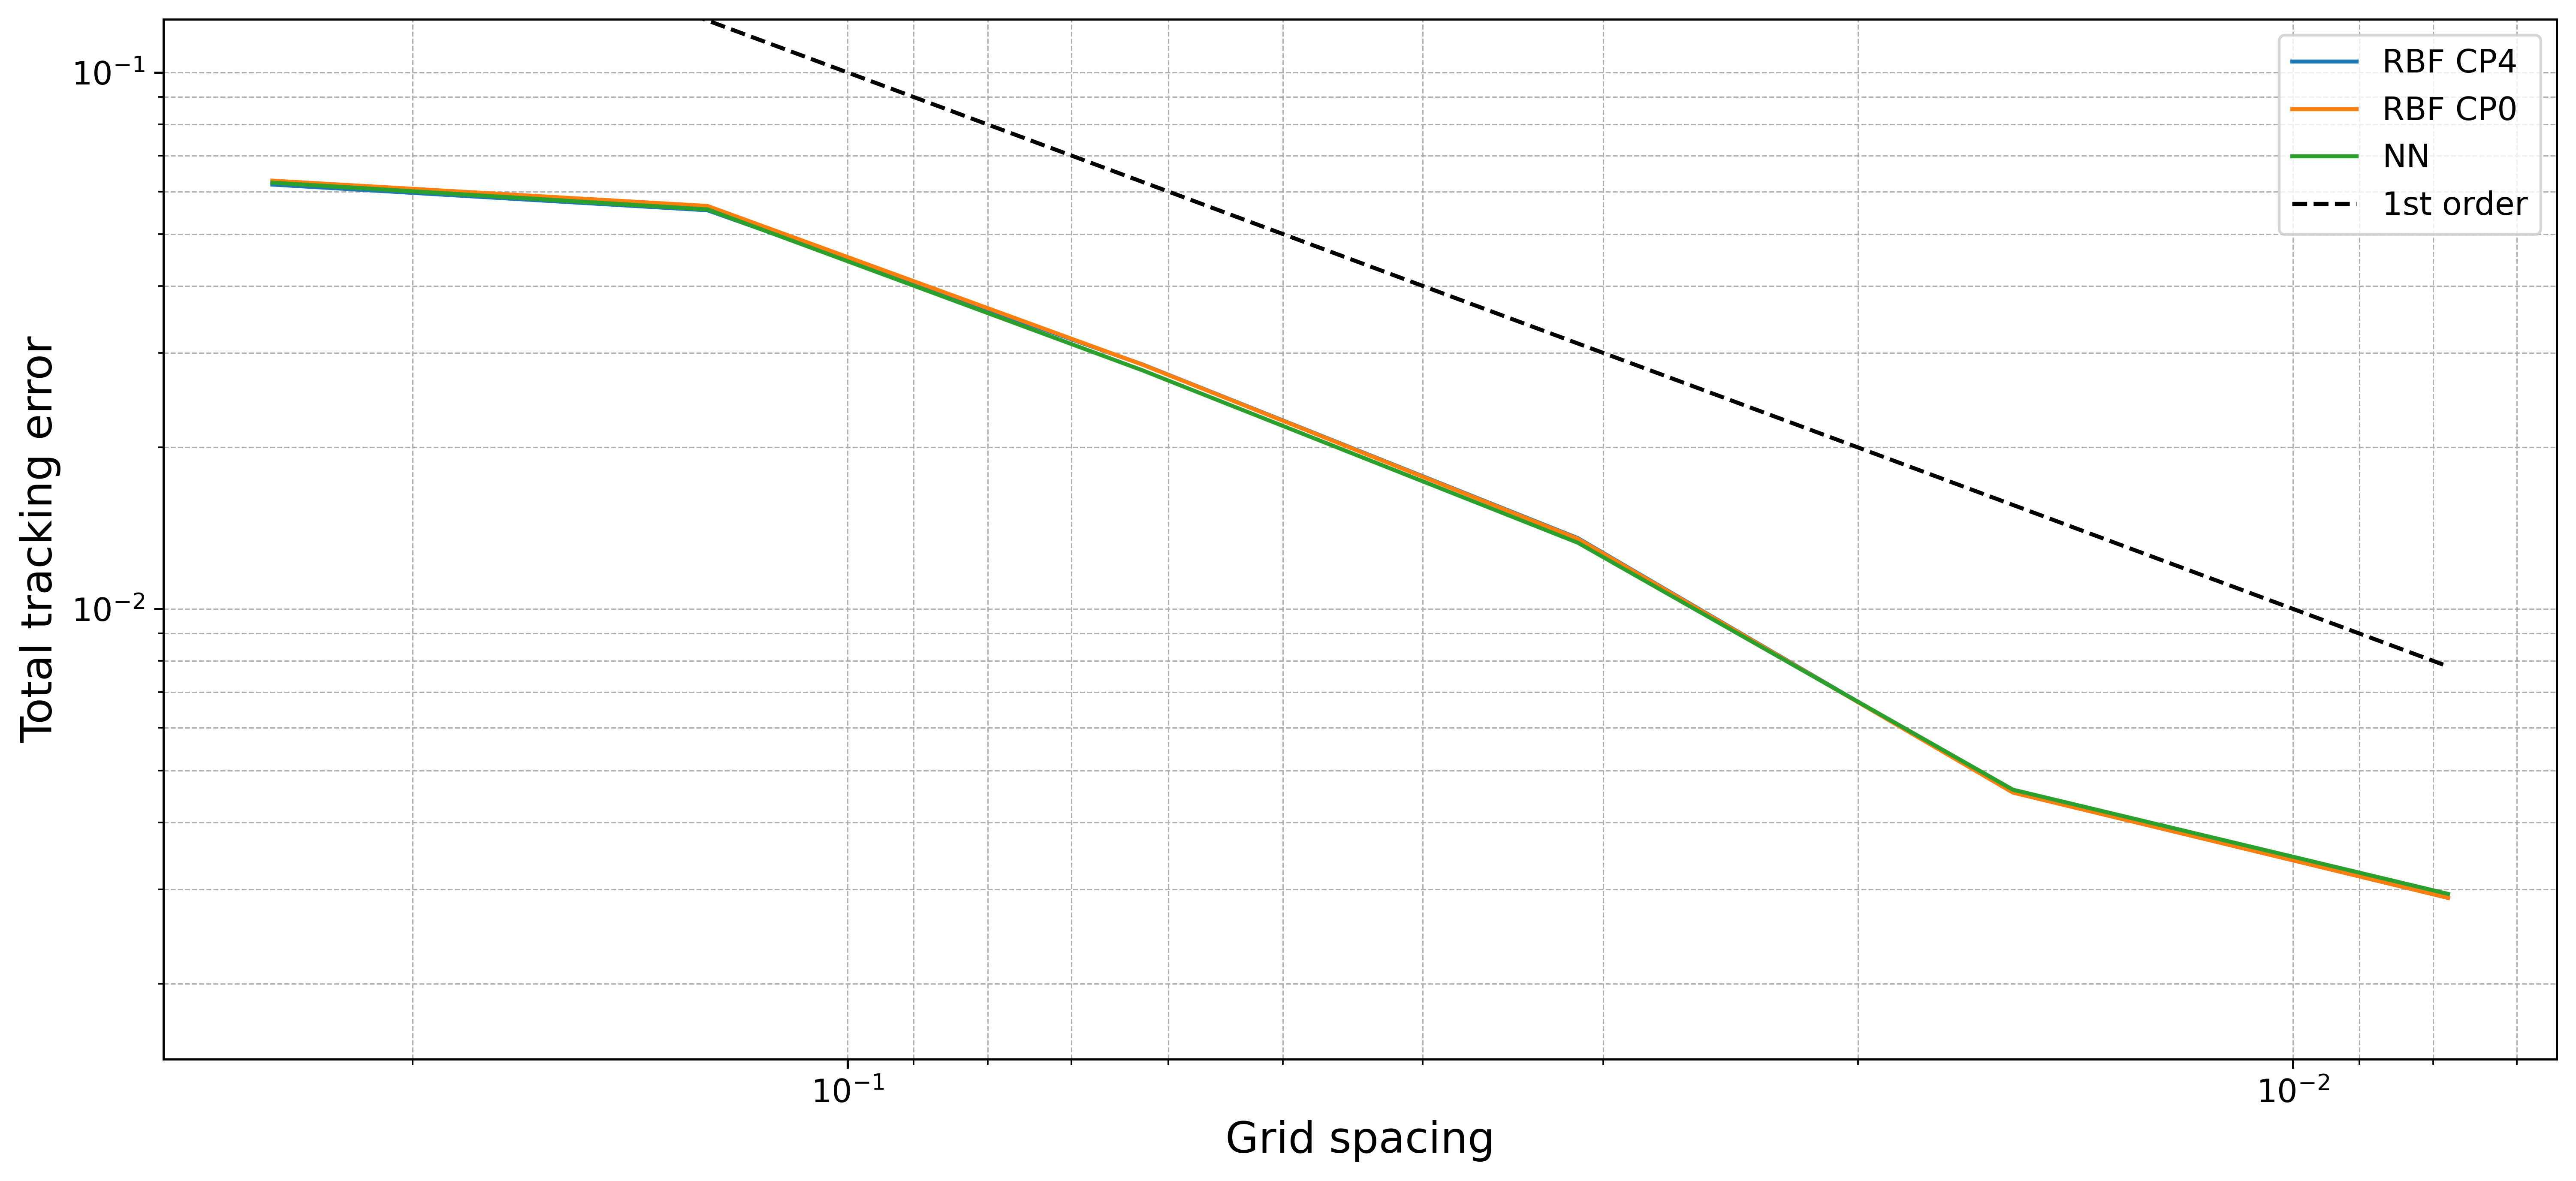

In [92]:
from matplotlib.axes import Axes


def plot_error_vs_time_step(data: pd.DataFrame, title: str, reference_lines = True, ax: Axes = None):
    """Plot the velocity error at a given timestep over different grid resolutions.
    
    Args:
        fig
        data: A DataFrame containing the error data. The index should be the grid
            resolution. Each column will be plotted as a separate line. 
        title: Title of the plot.
        reference_lines: If True, plot reference lines for first and second order
            convergence.
        ax: The axes to plot on. If None, create a new figure and axes.
    """

    # Create figure and axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 7))
        fig.set_dpi(450)

    # Plot the data
    for column in data.columns:
        ax.plot(data.index, data[column], label=column)
    
    # Plot reference lines
    if reference_lines:
        # First order convergence
        ax.plot(data.index, data.index, linestyle="--", color="black", label="1st order")
        # Second order convergence
        # ax.plot(data.index, data.index ** 2, linestyle="--", color="black", label="2nd order")

    # Add labels and legend
    # ax.set_title(title, fontsize=24)
    ax.legend(fontsize=12)
    ax.grid(which="both", linestyle="--", linewidth=0.5)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

    # Configure axes
    ax.set_xlabel("Grid spacing", fontsize=16)
    ax.set_xscale("log")
    ax.invert_xaxis()
    
    ax.set_ylabel("Total tracking error", fontsize=16)
    ax.set_yscale("log")
    ax.set_ylim(data.min().min() / 2, data.max().max() * 2)

plot_error_vs_time_step(df, "Tracking error converges over grid spacing")
